# 1. Описание задачи

Ранее в рамках предмета «Анализ неструктурированных данных» с целью получения практических навыков работы с текстами и API была выполнена первая часть большого проекта, заключающаяся в составлении собственного корпуса технических новостей с сайта HackerNews (https://news.ycombinator.com/). Во второй части проекта предлагалось провести тематическое моделирование на основе извлеченных данных, сделав предварительную обработку, векторизовать используемые в модели слова и кластеризовать полученные вектора, а также визуализировать и проанализировать результаты.

In [140]:
import gensim
import html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import re
import time
import warnings
import zipfile
from gensim.models import word2vec
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

stemmer = PorterStemmer()

stop_words = stopwords.words('english')

%matplotlib inline

pyLDAvis.enable_notebook()

warnings.filterwarnings("ignore")

# 2. Предобработка данных

Данные из прошлой части проекта не являются репрезентативными ввиду крайне маленького объема. Поэтому для работы использовались соответствующие данные с Kaggle: https://www.kaggle.com/hacker-news/hacker-news-corpus

In [2]:
data = pd.read_csv(zipfile.ZipFile('hacker-news-corpus.zip').open('hacker_news_sample.csv'), encoding='utf-8')

In [3]:
data.head(7)

,title,url,text,dead,by,score,time,type,id,parent,descendants,ranking,deleted,timestamp
0,NaN,NaN,&gt;<i>which leads me to say why are you using...,NaN,coldtea,NaN,1.390844e+09,comment,7131680,7127578.0,NaN,NaN,NaN,2014-01-27T17:31:13Z
1,NaN,NaN,I would like to point out some counter-example...,NaN,etanol,NaN,1.319396e+09,comment,3146879,3145330.0,NaN,NaN,NaN,2011-10-23T18:46:40Z
2,NaN,NaN,NaN,NaN,NaN,NaN,1.456641e+09,comment,11190089,11189361.0,NaN,NaN,True,2016-02-28T06:26:56Z
3,NaN,NaN,<i>Our msbuild implementation can now build Pr...,NaN,Locke1689,NaN,1.407882e+09,comment,8170491,8170071.0,NaN,NaN,NaN,2014-08-12T22:13:10Z
4,NaN,NaN,No matter how awful iPhoto is it's still bette...,NaN,miloshadzic,NaN,1.362573e+09,comment,5330773,5327590.0,NaN,NaN,NaN,2013-03-06T12:28:02Z
5,NaN,NaN,The existence of a way to shard searches doesn...,NaN,salsakran,NaN,1.302988e+09,comment,2454827,2452073.0,NaN,NaN,NaN,2011-04-16T21:04:23Z
6,#McConnelling,http://www.mcconnelling.org/,NaN,NaN,deepblueocean,2.0,1.395179e+09,story,7425232,NaN,0.0,NaN,NaN,2014-03-18T21:44:46Z


In [4]:
len(data)

3659697

In [5]:
data['type'].value_counts()

comment    3000341
story       653757
pollopt       2887
job           2260
poll           452
Name: type, dtype: int64

Нас интересуют только непустые новостные посты, то есть посты типа 'story'. Внутри неочищенных текстов есть различные html-теги и прочие «странные» и ненужные символы, а также URL-адреса разных страниц. В ходе предобработки мы последовательно от этого избавляемся. 

In [12]:
texts = [t for t in data[data['type'] == 'story']['text'] if str(t) != 'nan']
texts = [re.sub('<[^<]+?>', ' ', t) for t in texts]
texts = [html.unescape(t) for t in texts]
# https://mathiasbynens.be/demo/url-regex @imme_emosol
texts = [re.sub('(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?', ' ', t) for t in texts]
texts = [' '.join([w for w in t.split() if w.isalpha()]) for t in texts]

In [13]:
len(texts)

62466

Итак, мы получили выборку из 62466 текстов. Далее с помощью CountVectorizer переведем ее в матрицу частот терм-документ, попутно применяя токенизацию, приведение к строчным символам, удаление стоп-слов и стемминг.

In [14]:
class StemmedCountVectorizer(CountVectorizer):

    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))

In [15]:
start_time = time.time()
scv = StemmedCountVectorizer(max_df=0.95, min_df=2, max_features=5000, stop_words='english')
tf = scv.fit_transform(texts)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 30.934 seconds


tf - полученная матрица, с которой мы будем работать.

# 3. Тематическое моделирование

Построим две модели: Scikit-learn LDA и Gensim LDA для 20 топиков (результаты второй потом визуализируем).

### 3.1. Scikit-learn LDA

In [39]:
start_time = time.time()
lda = LatentDirichletAllocation(n_components=20, learning_method='batch', max_iter=50, n_jobs=7,random_state=13)
lda.fit(tf)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 4 minutes 2.223 seconds


In [127]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

In [128]:
print_top_words(lda, scv.get_feature_names(), 15)

Topic 0:
just like time peopl work think make thing want realli know feel year tri day

Topic 1:
use code data like server web host run sourc open api tool look work databas

Topic 2:
game play beauti gift look photo wed best hot free design fashion collect onlin great

Topic 3:
site post hn link like blog comment news read page search just googl articl hacker

Topic 4:
offer onlin best price buy qualiti servic home car cheap free provid shop sale india

Topic 5:
phone mobil window android appl devic iphon new featur laptop batteri screen camera mac ipad

Topic 6:
learn program book languag like school want start student know good year comput cours colleg

Topic 7:
write question problem research differ understand peopl use make paper test import way answer point

Topic 8:
job countri citi state servic locat uk dvd london local unit san visa american area

Topic 9:
provid manag servic softwar secur comput solut offic technolog data system train support cloud offer

Topic 10:
develop wo

Заметим, что результаты получились довольно осмысленные, и темы в целом интерпретируемые. Например, видно, что топик 8 имеет географический смысл, топик 11 относится к IT-направлению, топик 13 близок к медицине, а топик 5 - о гаджетах. В качестве бренда в первой части проекта был выбран Youtube, и он с большой вероятностью может относиться к топику 18 (просмотр онлайн-трансляций), 12 (скачивание музыки или видео) или 19 (средства работы с изображениями, видео и другими документами). Так что можно утверждать, что данные темы связаны с брендом.

In [45]:
start_time = time.time()
X_topics = lda.transform(tf)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 10.809 seconds


### 3.2. Gensim LDA

Для построения модели Gensim LDA нужно «в открытую» предобработать данные, вне CountVectorizer.

In [87]:
start_time = time.time()
text_list = [t.lower() for t in texts]
text_list = [word_tokenize(t) for t in text_list]
text_list = [[w for w in t if w not in stop_words] for t in text_list]
text_list = [[w for w in t if w.isalpha()] for t in text_list]
text_list = [t for t in text_list if t]
text_list = [[stemmer.stem(w) for w in t] for t in text_list]
#text_list = [[w for w in t if w in scv.get_feature_names()] for t in text_list]
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 48.877 seconds


In [88]:
start_time = time.time()
feature_names = scv.get_feature_names()
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))
for i in range(len(text_list)):
    print('Processing text {} of {} ({}%), time running: {} minutes {} seconds\r'.format(i + 1, len(text_list),
                                round((i + 1) / len(text_list) * 100, 1), int((time.time() - start_time) // 60),
                                round((time.time() - start_time) % 60)), end='')
    text_list[i] = [w for w in text_list[i] if w in feature_names]

Time running: 0 minutes 0.005 seconds


In [94]:
start_time = time.time()
dictionary = gensim.corpora.Dictionary(text_list)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 1.343 seconds


In [95]:
start_time = time.time()
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 1.131 seconds


In [122]:
start_time = time.time()
gensim_lda = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, passes=10)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 7 minutes 12.336 seconds


In [126]:
for i in gensim_lda.print_topics(gensim_lda.num_topics):
    for j in i:
        print(j)

0
0.034*"de" + 0.027*"home" + 0.017*"offic" + 0.017*"la" + 0.014*"san" + 0.013*"citi" + 0.012*"hous" + 0.012*"properti" + 0.012*"air" + 0.011*"famili"
1
0.037*"servic" + 0.023*"provid" + 0.020*"web" + 0.018*"custom" + 0.017*"busi" + 0.014*"websit" + 0.013*"manag" + 0.013*"host" + 0.013*"product" + 0.012*"market"
2
0.142*"app" + 0.052*"game" + 0.044*"mobil" + 0.028*"android" + 0.028*"iphon" + 0.026*"develop" + 0.024*"download" + 0.021*"applic" + 0.021*"appl" + 0.021*"io"
3
0.037*"onlin" + 0.032*"best" + 0.026*"offer" + 0.024*"free" + 0.024*"price" + 0.021*"buy" + 0.016*"qualiti" + 0.016*"visit" + 0.015*"shop" + 0.015*"get"
4
0.024*"busi" + 0.013*"stock" + 0.013*"entrepreneur" + 0.012*"innov" + 0.012*"industri" + 0.011*"model" + 0.011*"trade" + 0.011*"market" + 0.011*"yc" + 0.010*"tax"
5
0.072*"design" + 0.025*"phone" + 0.018*"featur" + 0.014*"screen" + 0.014*"imag" + 0.013*"camera" + 0.013*"player" + 0.012*"mobil" + 0.012*"video" + 0.011*"new"
6
0.071*"news" + 0.055*"event" + 0.048*"hac

В данном случае тоже получаются достаточно интерпретируемые темы - к примеру, «школьный топик» 13, топик 5, относящийся к дизайну гаджетов, топик 2, относящийся к их содержимому, «бизнес-топик» 4. Youtube можно отнести к топику 8 (просмотр картинок, изображений, прослушивание музыки), а также (возможно, вероятнее) - к топику 10 (социальные сети).

### 3.3. Визуализация

Для визуализации результатов тематического моделирования использовался пакет pyLDAvis.

In [123]:
start_time = time.time()
gensim_data = pyLDAvis.gensim.prepare(gensim_lda, doc_term_matrix, dictionary)
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 57.59 seconds


In [124]:
gensim_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      19.408454        1       1  0.220839  0.060449
16     12.487738        1       2  0.242233  0.036144
11      7.610397        1       3  0.173525 -0.093150
1       7.362486        1       4  0.100745  0.055858
15      7.044639        1       5  0.115096  0.176389
17      5.700066        1       6  0.136489 -0.108874
13      5.680999        1       7  0.196250  0.105689
3       4.124652        1       8 -0.010450  0.041503
12      4.022091        1       9  0.040096  0.015444
10      3.500084        1      10  0.049189 -0.162968
5       3.024000        1      11 -0.068795 -0.074912
4       2.979950        1      12 -0.034925  0.163892
18      2.888254        1      13 -0.008131 -0.198105
2       2.733989        1      14 -0.028528 -0.243362
0       2.520342        1      15 -0.180442  0.123328
8       2.377435        1      16 -0.121272 -0.076846
19      2.133035        1      17 -0.181554  0.209189
7       1.697443        1      18 -0.151463  0.062261
6       1.372175        1      19 -0.224716 -0.046768
14      1.331769        1      20 -0.264187 -0.045160, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
303   Default   6607.000000         app   6607.000000  30.0000  30.0000
6     Default  13978.000000        work  13978.000000  29.0000  29.0000
147   Default  16925.000000         use  16925.000000  28.0000  28.0000
20    Default   5156.000000      design   5156.000000  27.0000  27.0000
9     Default   8920.000000     develop   8920.000000  26.0000  26.0000
32    Default   6242.000000      servic   6242.000000  25.0000  25.0000
346   Default   4779.000000       learn   4779.000000  24.0000  24.0000
73    Default   3912.000000       email   3912.000000  23.0000  23.0000
293   Default   7595.000000     compani   7595.000000  22.0000  22.0000
188   Default   8652.000000       peopl   8652.000000  21.0000  21.0000
66    Default   4015.000000         job   4015.000000  20.0000  20.0000
684   Default   4029.000000        post   4029.000000  19.0000  19.0000
5     Default   5609.000000        site   5609.000000  18.0000  18.0000
810   Default   4540.000000       onlin   4540.000000  17.0000  17.0000
343   Default   2466.000000        game   2466.000000  16.0000  16.0000
187   Default   5008.000000        busi   5008.000000  15.0000  15.0000
380   Default   5079.000000      provid   5079.000000  14.0000  14.0000
812   Default   2101.000000        news   2101.000000  13.0000  13.0000
474   Default   5267.000000        best   5267.000000  12.0000  12.0000
275   Default   2697.000000       mobil   2697.000000  11.0000  11.0000
581   Default   3705.000000       googl   3705.000000  10.0000  10.0000
169   Default   3405.000000     program   3405.000000   9.0000   9.0000
27    Default   4920.000000       creat   4920.000000   8.0000   8.0000
219   Default   4948.000000     startup   4948.000000   7.0000   7.0000
141   Default   3008.000000       share   3008.000000   6.0000   6.0000
298   Default   5797.000000        year   5797.000000   5.0000   5.0000
308   Default   6350.000000         web   6350.000000   4.0000   4.0000
665   Default   5216.000000        idea   5216.000000   3.0000   3.0000
513   Default   2879.000000       video   2879.000000   2.0000   2.0000
505   Default   2745.000000        live   2745.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
3030  Topic20    463.597176        obat    464.556513   4.3166  -3.8880
2790  Topic20    419.208503      dengan    420.167840   4.3164  -3.9886
2914  Topic20    410.889049        hair    411.848386   4.3163  -4.0087
3129  Topic20    389.732448       untuk    390.691784   4.3162  -4.0615
3346  Topic20    377.894279          di    378.853616   4.3161  -4.0924
1439  Topic20    325.570128      

На диаграмме видно, что некоторые классы лежат ближе друг к другу (и иногда даже пересекаются), некоторые - дальше. Действительно, это соответствует тому, что в приведенных выше рассуждениях в разных кластерах периодически выделялись в принципе похожие по сути слова.

# 4. Word2Vec

Вновь проведем необходимую аналогичную предобработку текстов.

In [147]:
start_time = time.time()
texts = [t for t in data[data['type'] == 'story']['text'] if str(t) != 'nan']
texts = [re.sub('<[^<]+?>', ' ', t) for t in texts]
texts = [html.unescape(t) for t in texts]
# https://mathiasbynens.be/demo/url-regex @imme_emosol
texts = [re.sub('(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?', ' ', t) for t in texts]
texts = [t.lower() for t in texts]
texts = [word_tokenize(t) for t in texts]
texts = [[w for w in t if w not in stop_words] for t in texts]
texts = [[w for w in t if w.isalpha()] for t in texts]
texts = [t for t in texts if t]
texts = [[stemmer.stem(w) for w in t] for t in texts]
#texts = [' '.join(t) for t in texts]
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 1 minutes 9.66 seconds


In [154]:
texts[2]

['bitbucket',
 'seen',
 'larg',
 'increas',
 'incid',
 'last',
 'month',
 'outag',
 'incid',
 'affect',
 'team',
 'product',
 'go',
 'atlassian']

In [157]:
words = np.hstack(texts)
words = np.unique(words)
words.shape

(62471,)

### 4.1. Кластеризация

Кластеризацию проведем с помощью KMeans.

Time running: 0 minutes 11.985 seconds


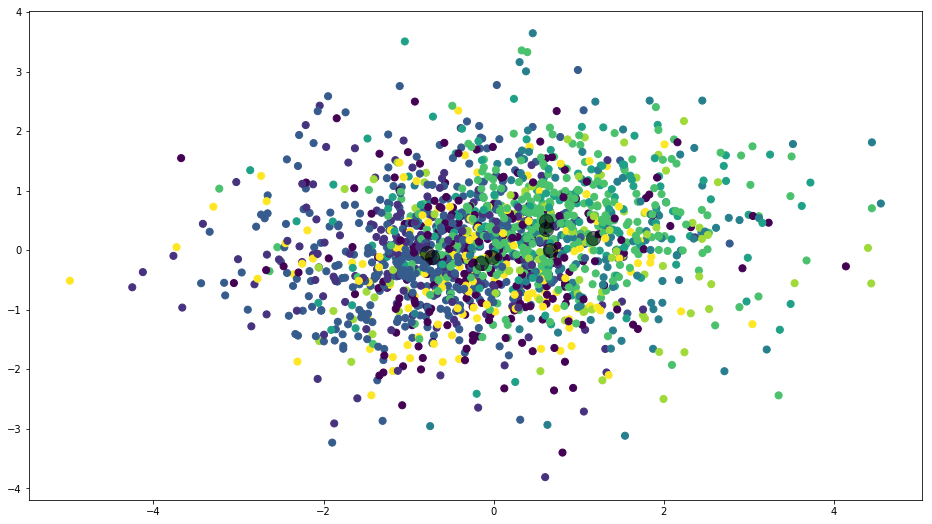

In [179]:
start_time = time.time()
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=200, workers=4)
words_vec = []
for w in model.wv.vocab:
    words_vec.append(model[w])
km = KMeans(random_state=23, n_jobs=7)
km.fit(words_vec)
plt.figure(figsize=(16,9))
plt.scatter(np.array(words_vec)[:, 0], np.array(words_vec)[:, 1], c=km.labels_, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 10.934 seconds


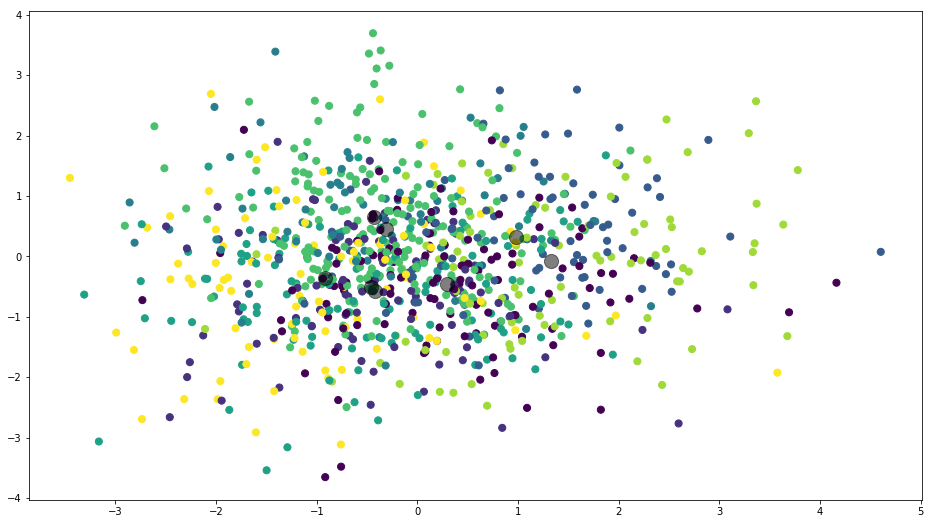

In [180]:
start_time = time.time()
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=500, workers=4)
words_vec = []
for w in model.wv.vocab:
    words_vec.append(model[w])
km = KMeans(random_state=23, n_jobs=7)
km.fit(words_vec)
plt.figure(figsize=(16,9))
plt.scatter(np.array(words_vec)[:, 0], np.array(words_vec)[:, 1], c=km.labels_, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

Time running: 0 minutes 9.786 seconds


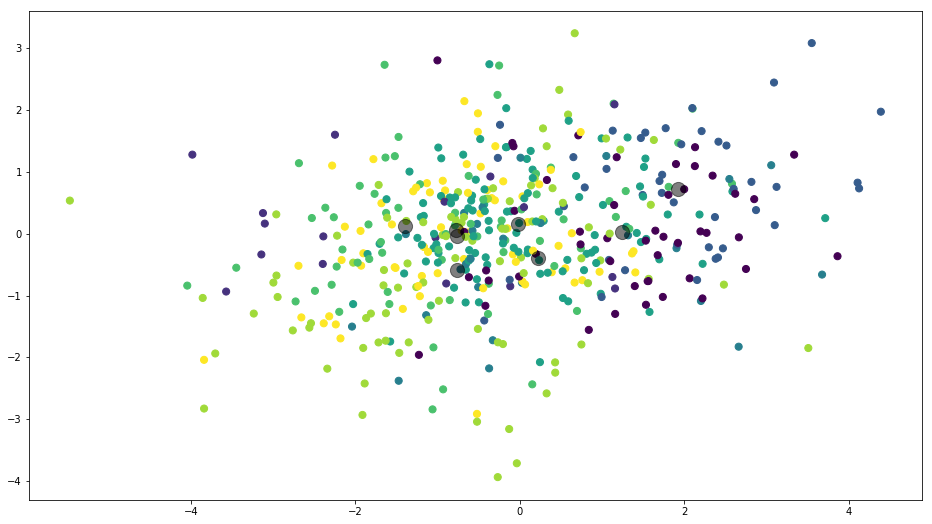

In [181]:
start_time = time.time()
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=1000, workers=4)
words_vec = []
for w in model.wv.vocab:
    words_vec.append(model[w])
km = KMeans(random_state=23, n_jobs=7)
km.fit(words_vec)
plt.figure(figsize=(16,9))
plt.scatter(np.array(words_vec)[:, 0], np.array(words_vec)[:, 1], c=km.labels_, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print('Time running: {} minutes {} seconds'.format(int((time.time() - start_time) // 60),
                                                   round((time.time() - start_time) % 60, 3)))

### 4.2. Визуализация

Теперь построим и обучим модель t-SNE и визуализируем результат.

In [136]:
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model):
    "Creates TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    # Поскольку размер входных данных велик, установим параметр perplexity = 40
    tsne_model = TSNE(perplexity = 40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    # визуализируем результаты 
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

Теперь обучим word2vec на полученном выше корпусе слов, визуализируем результат и попробуем менять параметр min_count.

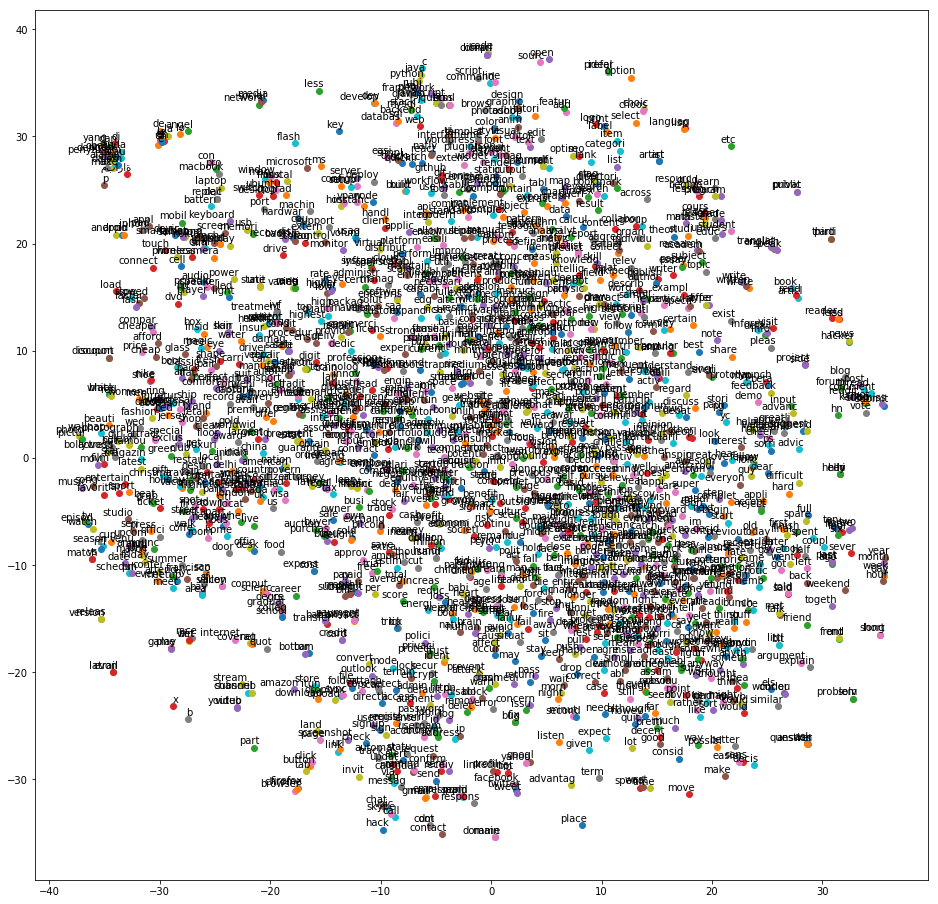

In [137]:
# min_count=200
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=200, workers=4)
tsne_plot(model)

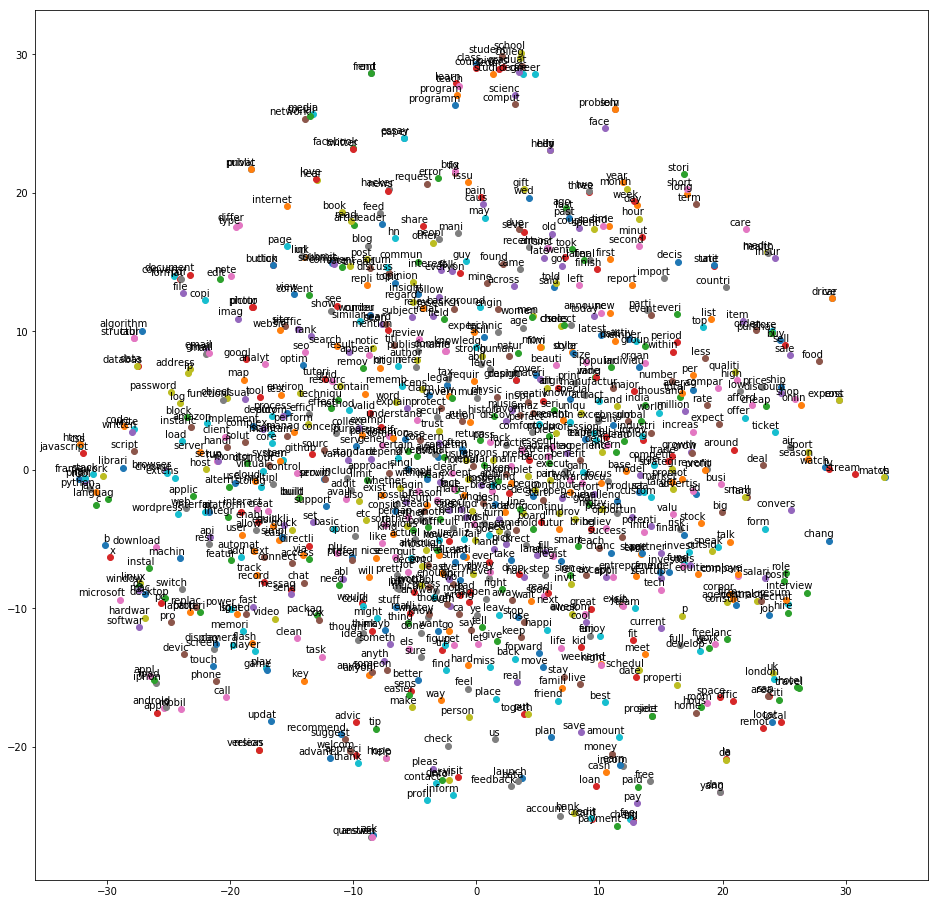

In [138]:
# min_count=500
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

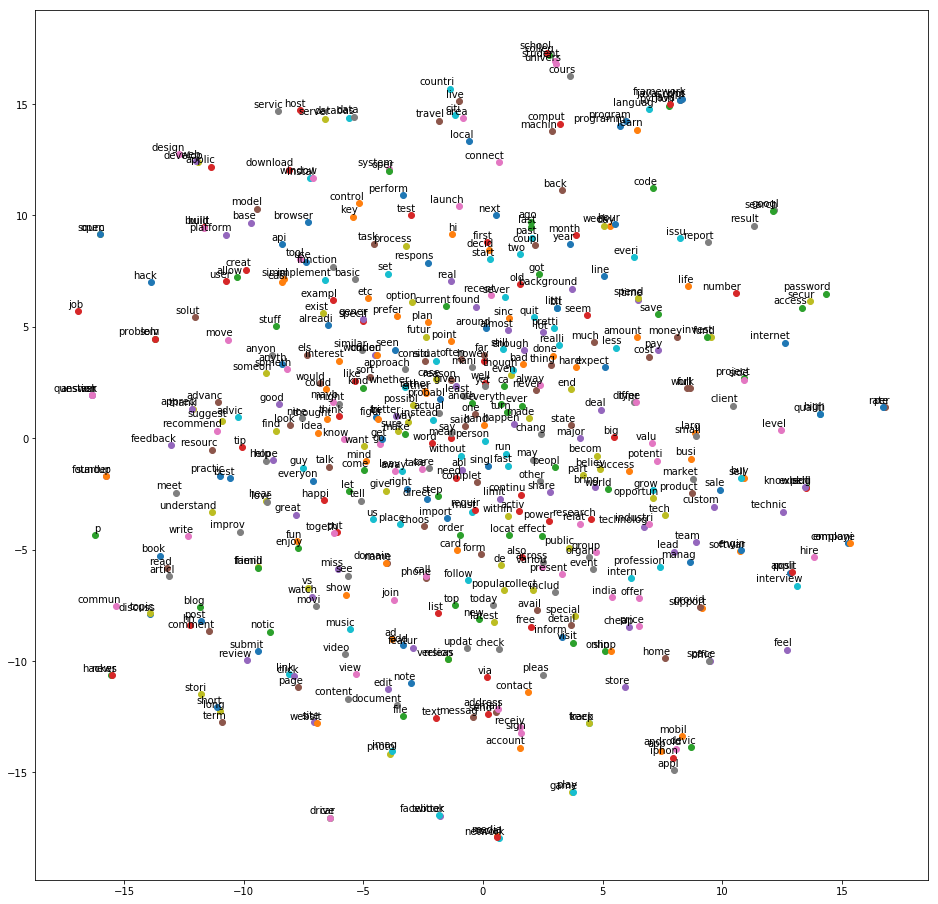

In [139]:
# min_count=1000
model = word2vec.Word2Vec(texts, size=100, window=20, min_count=1000, workers=4)
tsne_plot(model)

Видно, что при увеличении параметра min_count модель становится более избирательной; можно увидеть отдельно стоящее слово feel (справа снизу), или, например, группу слов access, secur и password (справа сверху).

# 5. Заключение

В рамках данной части проекта на основе данных с сайта https://news.ycombinator.com/ было проведено тематическое моделирование и кластеризация эмбеддингов слов. Результаты моделирования и векторизации слов были визуализированы.

Видно, что при обсуждении Youtube обсуждаются различные онлайн-трансляции, средства для скачивания и просмотра видеозаписей, а также прочие крупные социальные сети. Также стоит заметить, что данный бренд в первую очередь относится к словам, употребляющихся обычно в контексте развлечений (сериалы, спорт и т.д.).